# Transfer Learning with MobileNetV2

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa

from train_utils.augmenters import data_augmenter, data_augmenter_fruit360
from train_utils.callbacks import LossHistory, LRCallBack
from train_utils.utils import is_in
from train_utils.losses import crossentropy_loss
from train_utils.dataset import food_dataset

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<a name='1'></a>
## 2 - Datasets

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset, cv_dataset = food_dataset(BATCH_SIZE, IMG_SIZE)

from train_utils.dataset import fruit360_classes, all_class_names

print(
    tf.data.experimental.cardinality(train_dataset),
    train_dataset,
    sep = '\n'
)

Found 594 files belonging to 297 classes.
Using 297 files for training.
Found 594 files belonging to 297 classes.
Using 297 files for validation.
Found 100000 files belonging to 100 classes.
Using 99000 files for training.
Found 100000 files belonging to 100 classes.
Using 1000 files for validation.

Found 2734 files belonging to 20 classes.
Using 2188 files for training.
Found 2734 files belonging to 20 classes.
Using 546 files for validation.

Found 4000 files belonging to 80 classes.
Using 3200 files for training.
Found 4000 files belonging to 80 classes.
Using 800 files for validation.

Found 89089 files belonging to 97 classes.
Using 87308 files for training.
Found 89089 files belonging to 97 classes.
Using 1781 files for validation.

tf.Tensor(6002, shape=(), dtype=int64)
<ConcatenateDataset shapes: ((None, 224, 224, 3), (None, None)), types: (tf.float32, tf.float32)>


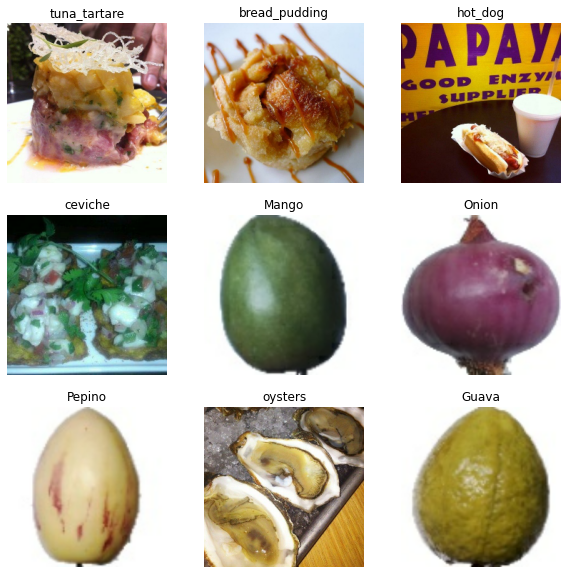

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i+9].numpy().astype("uint8"))
        plt.title(all_class_names[tf.math.argmax(labels[i+9])])
        plt.axis("off")

<a name='2'></a>
## 3 - Preprocess and Augment Training Data
(https://www.tensorflow.org/tutorials/images/data_augmentation).

In [4]:
'''AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)'''

'AUTOTUNE = tf.data.experimental.AUTOTUNE\ntrain_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)\ntrain_dataset = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True)'

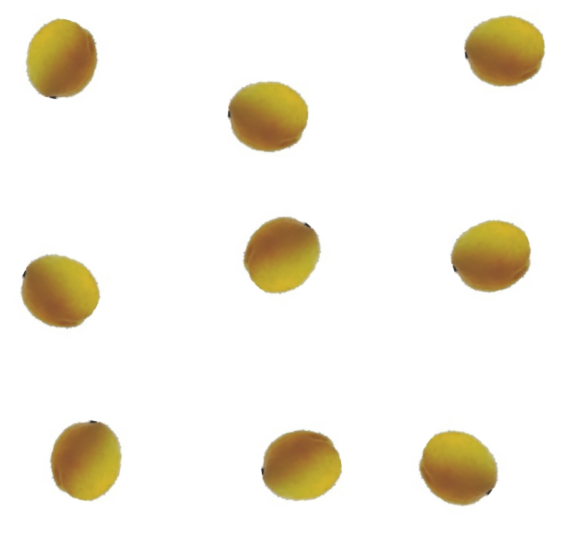

In [5]:
data_augmentation = data_augmenter_fruit360()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

<a name='3'></a>
## 4 - Using MobileNetV3


In [6]:
IMG_SHAPE = IMG_SIZE + (3,)

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

mobile_v3_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [7]:
print("Number of layers in the base model: ", len(mobile_v3_model.layers))

Number of layers in the base model:  276


In [8]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape, label_batch.shape)
NUM_CLASSES = label_batch.shape[-1]

(32, 224, 224, 3) (32, 297)


<a name='ex-2'></a>
### model

In [9]:
class CustomModel(tf.keras.Model):
    food_augmenter = data_augmenter()
    fruit_augmenter = data_augmenter_fruit360()
    fruit_indices = tf.constant(
        [all_class_names.index(fruit) for fruit in fruit360_classes]
    )

    def train_step(self, data):
        x, y = data
        class_indices = tf.math.argmax(y, -1)
        isfr = is_in(class_indices, self.fruit_indices)
        isfr = tf.expand_dims(tf.expand_dims(tf.expand_dims(isfr, -1), -1), -1)
        x = tf.where(
            isfr, 
            self.fruit_augmenter(x), 
            self.food_augmenter(x),
        )
        return super().train_step((x, y))


In [10]:
def food_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
    )
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 259
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs) 
    x = base_model(x) 
    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dense(640, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    prediction_layer = tfl.Dense(NUM_CLASSES, activation='softmax')
    
    outputs = prediction_layer(x) 
    model = CustomModel(inputs, outputs)
    
    return model

model2 = food_model()
model2.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 297)               190377    
Total params: 5,236,649
Trainable params: 2,549,737
Non-trainable params: 2,686,912
____________________________________

### Estimate optimal learning rate

In [11]:
history = LossHistory(batches=200)
optimizer = tf.keras.optimizers.Adam()

model2 = food_model(IMG_SIZE)
model2.compile(
    loss=crossentropy_loss,
    optimizer=optimizer,
)
model2.fit(
    train_dataset.take(history.batches),
    callbacks=[history],
)
    
plt.figure(figsize=(8, 8))
plt.plot(history.exp_lrs, history.losses)
plt.ylabel('Loss')
plt.xlabel('Learning Rate Exponent')
plt.title('Training Loss')

 10/200 [>.............................] - ETA: 36s - loss: 0.0237

InvalidArgumentError:  required broadcastable shapes at loc(unknown)
	 [[node crossentropy_loss/Mul (defined at C:\Users\arlak\PycharmProjects\indianFoodTf\train_utils\losses.py:8) ]] [Op:__inference_train_function_25973]

Errors may have originated from an input operation.
Input Source operations connected to node crossentropy_loss/Mul:
 crossentropy_loss/Prediction_Log (defined at C:\Users\arlak\PycharmProjects\indianFoodTf\train_utils\losses.py:6)	
 IteratorGetNext (defined at <ipython-input-11-82ff564d2dee>:9)

Function call stack:
train_function


In [ ]:
optimizer = tf.keras.optimizers.Adam()

# evaluation metrics
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3'),
    tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5'),
]

### END CODE HERE

model2 = food_model(IMG_SIZE)
model2.compile(
    loss=crossentropy_loss,
    optimizer=optimizer,
    metrics=metrics,
)

In [ ]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()
lr_callback = LRCallBack(epochs=5, l_r=(-3, -4))

history = model2.fit(
    train_dataset, 
    validation_data=cv_dataset, 
    epochs=lr_callback.epochs,
    verbose=0,
    callbacks=[tqdm_callback, lr_callback],
)
history.history['accuracy']

plt.figure(figsize=(8, 8))
plt.plot(lr_callback.batch_losses)
plt.ylabel('Loss')
plt.xlabel('Batches')
plt.title('Training Loss')

Plot the training and validation accuracy:

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.05])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()